# Data Ingest and Benchmark

This notebook demonstrates GPU-accelerated telemetry loading with cuDF and Unified Virtual Memory (UVM), and benchmarks pandas vs cuDF. Inspired by [Speed Up Data Analytics on GPUs](https://developers.google.com/learn/pathways/speed-up-data-analytics-GPUs).

<a href="https://colab.research.google.com/github/KarthikSriramGit/Project-Insight/blob/main/notebooks/01_data_ingest_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/Project-Insight.git")
    get_ipython().run_line_magic("cd", "Project-Insight")
    get_ipython().system("pip install -q pandas pyarrow numpy matplotlib")
    get_ipython().system("pip install -q cudf-cu12 2>/dev/null || true")
except Exception:
    pass

/content/Project-Insight/Project-Insight


In [8]:
# Setup: Colab runs from repo root after clone
import sys
from pathlib import Path
ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

ROOT=/content/Project-Insight/Project-Insight


## Generate synthetic telemetry

In [9]:
# Generate synthetic telemetry using project script
import subprocess
parquet_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
if not parquet_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", "500000",
        "--output-dir", "data/synthetic",
        "--format", "parquet",
    ], check=True, cwd=str(ROOT))
else:
    print(f"Data exists: {parquet_path}")

## Load with cuDF and UVM spill

In [10]:
from src.ingest.cudf_loader import load_telemetry

df = load_telemetry(str(parquet_path), spill=True)
print(df.head())
print(f"Shape: {df.shape} (backend: {'cuDF' if 'cudf' in str(type(df)) else 'pandas'})")

   timestamp_ns vehicle_id sensor_type       accel_x       accel_y  \
0             0       V001         imu  -0.372758361   0.333944348   
1             0       V006         imu  -0.077508045  -0.798546383   
2             0       V009         can          <NA>          <NA>   
3             0       V000      camera          <NA>          <NA>   
4             0       V007         can          <NA>          <NA>   

       accel_z        gyro_x        gyro_y        gyro_z orientation_w  ...  \
0  9.533070595  -0.009396926  -0.002109831   0.000577826   0.991726478  ...   
1  9.930926544   0.003416054   -0.00533013  -0.014516519   0.999315578  ...   
2         <NA>          <NA>          <NA>          <NA>          <NA>  ...   
3         <NA>          <NA>          <NA>          <NA>          <NA>  ...   
4         <NA>          <NA>          <NA>          <NA>          <NA>  ...   

  gear_position latitude longitude altitude_m velocity_north velocity_east  \
0          <NA>     <NA>  

## Benchmark: pandas vs cuDF

In [11]:
from src.ingest.benchmark_loader import run_benchmark, benchmark_to_dataframe

results = run_benchmark(parquet_path)
bm_df = benchmark_to_dataframe(results)
print(bm_df)

  backend operation    time_s   memory_mb
0  pandas      load  0.387160   28.195372
1  pandas   groupby  0.115188   23.763331
2  pandas    filter  0.008318    3.144314
3  pandas      sort  0.161602  133.519554
4    cudf      load  0.208971    0.235997
5    cudf   groupby  0.040917    0.032084
6    cudf    filter  0.114129    0.213547
7    cudf      sort  0.090768    0.222069


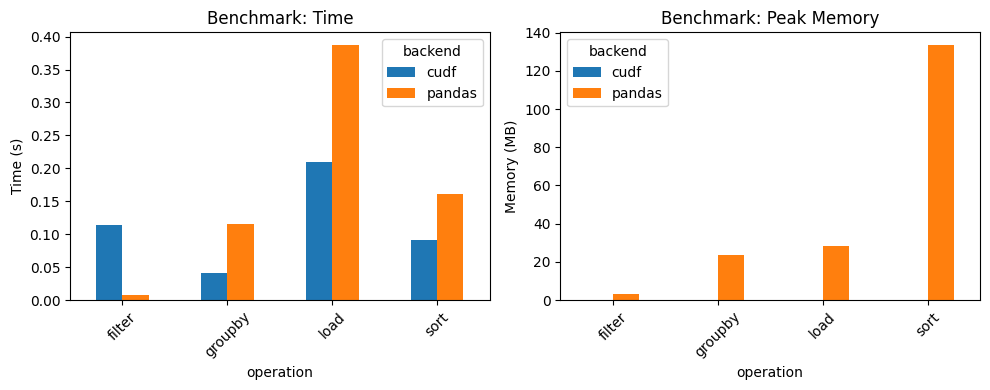

In [12]:
import matplotlib.pyplot as plt

pivot_time = bm_df.pivot(index="operation", columns="backend", values="time_s")
pivot_mem = bm_df.pivot(index="operation", columns="backend", values="memory_mb")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pivot_time.plot(kind="bar", ax=ax[0], rot=45, legend=True)
ax[0].set_ylabel("Time (s)")
ax[0].set_ylim(bottom=0)
ax[0].set_title("Benchmark: Time")
pivot_mem.plot(kind="bar", ax=ax[1], rot=45, legend=True)
ax[1].set_ylabel("Memory (MB)")
ax[1].set_ylim(bottom=0)
ax[1].set_title("Benchmark: Peak Memory")
plt.tight_layout()
plt.show()